<a href="https://colab.research.google.com/github/MohsenLotfii/School_electricity/blob/main/1_Schools_electricity_K_mean_(Jan_Feb_2023_24)__04_Nov_2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


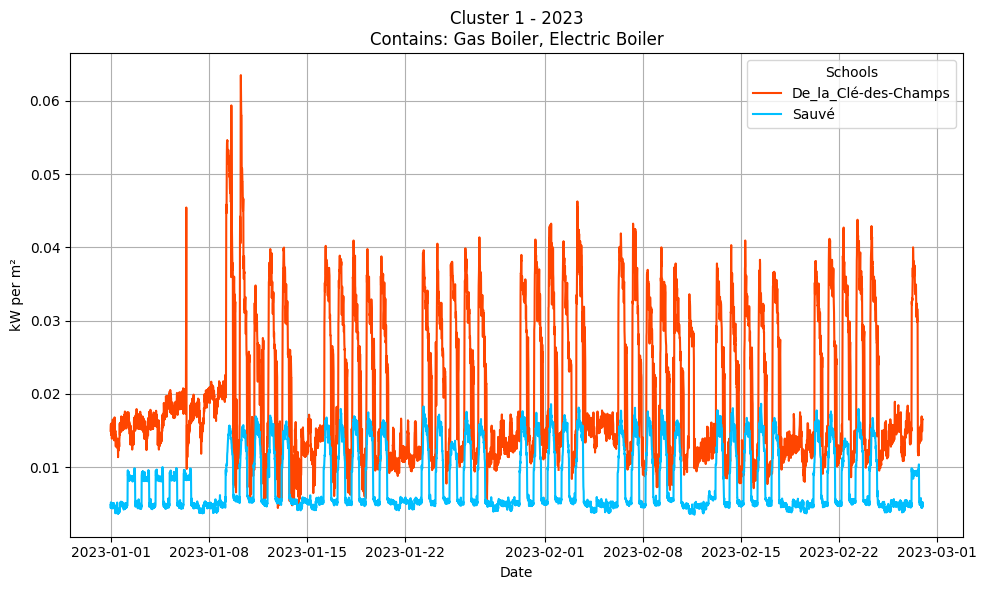

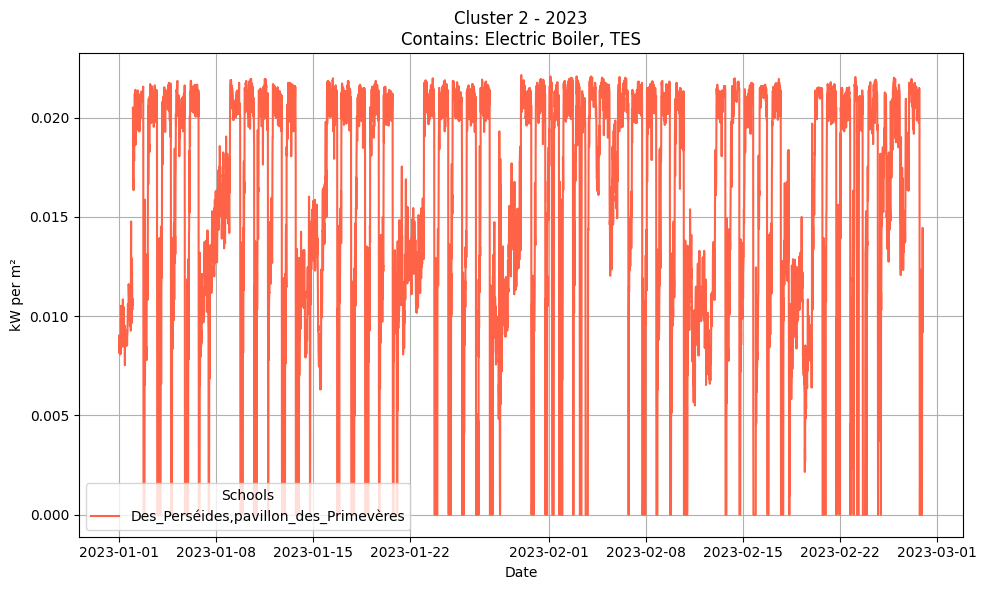

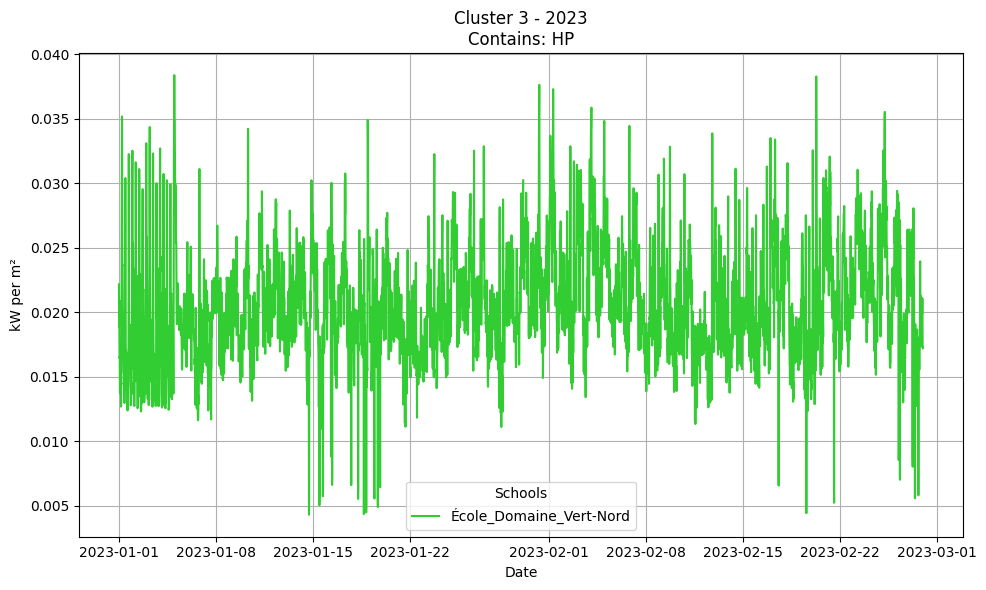

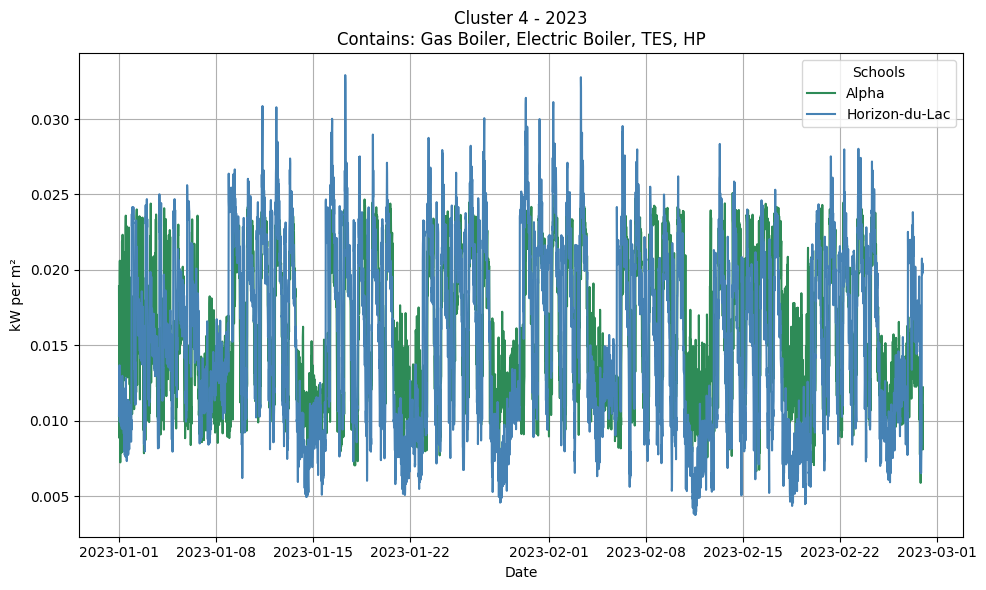

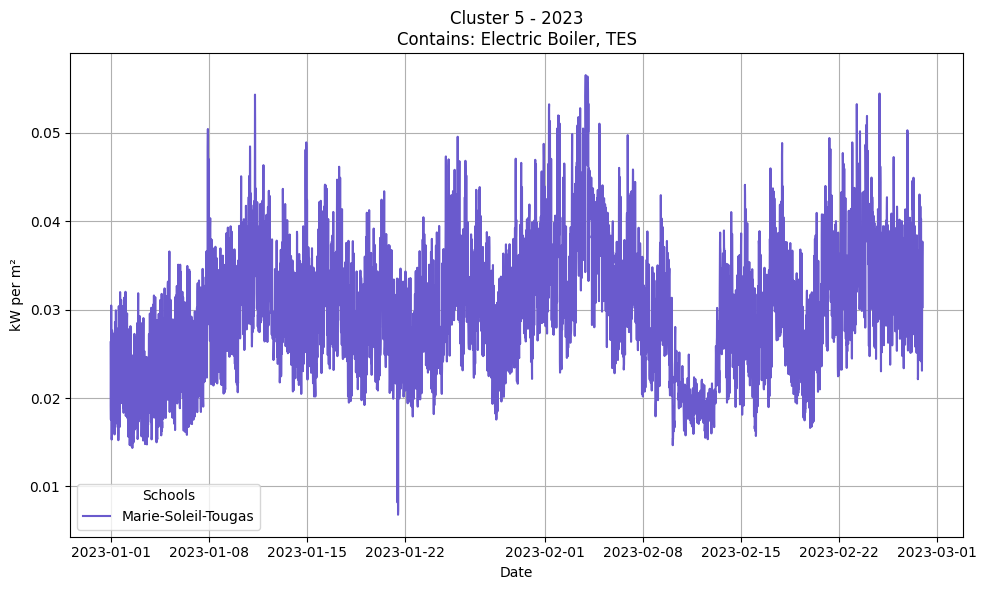

In [ ]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# Floor areas for each school
floorAreas = {
    "Alpha": 7742,
    "Curé-Paquin": 4579,
    "Des_Perséides,pavillon_des_Primevères": 3108,
    #"Gaston-Pilon(300209825)": 5103,
    #"Gaston-Pilon(300206515)": 5103,
    #"Gaston-Pilon(300205293)": 5103,
    "De_la_Clé-des-Champs": 2999,
    "Horizon-du-Lac": 4977,
    "Marie-Soleil-Tougas": 5478,
    "École_Domaine_Vert-Nord": 5717,
    "Sauvé": 3842,
    #"Village-des-Jeunes (300206655)": 2306,
    #"Village-des-Jeunes (300206667)": 2306,
    "Terre des jeunes": 3710,
    "Notre-Dame": 3512,
    "Secondaire Rive-Nord": 9780,
    "De la Clairière": 3220,
}

# Mechanical equipment details for each school
equipment = {
    "Alpha": {"Gas Boiler": 3, "Electric Boiler": 1, "TES": 1, "HP": 0},
    "Curé-Paquin": {"Gas Boiler": 0, "Electric Boiler": 1, "TES": 1, "HP": 0, "Radiant Heating": 1, "PV Panel": 1},
    "Des_Perséides,pavillon_des_Primevères": {"Gas Boiler": 0, "Electric Boiler": 1, "TES": 1, "HP": 0},
    #"Gaston-Pilon(300209825)": {"Gas Boiler": 1, "Electric Boiler": 1, "TES": 0, "HP": 0},
    #"Gaston-Pilon(300206515)": {"Gas Boiler": 1, "Electric Boiler": 1, "TES": 0, "HP": 0},
    #"Gaston-Pilon(300205293)": {"Gas Boiler": 1, "Electric Boiler": 1, "TES": 0, "HP": 0},
    "De_la_Clé-des-Champs": {"Gas Boiler": 1, "Electric Boiler": 1, "TES": 0, "HP": 0},
    "Horizon-du-Lac": {"Gas Boiler": 1, "Electric Boiler": 1, "TES": 1, "HP": 36},
    "Marie-Soleil-Tougas": {"Gas Boiler": 0, "Electric Boiler": 1, "TES": 1, "HP": 0},
    "École_Domaine_Vert-Nord": {"Gas Boiler": 0, "Electric Boiler": 0, "TES": 0, "HP": 1},
    "Sauvé": {"Gas Boiler": 2, "Electric Boiler": 1, "TES": 0, "HP": 0},
    #"Village-des-Jeunes (300206655)": {"Gas Boiler": 1, "Electric Boiler": 1, "TES": 0, "HP": 0},
    #"Village-des-Jeunes (300206667)": {"Gas Boiler": 1, "Electric Boiler": 1, "TES": 0, "HP": 0},
    "Terre des jeunes": {"Gas Boiler": 2, "Electric Boiler": 0, "TES": 0, "HP": 0},
    "Notre-Dame": {"Gas Boiler": 1, "Electric Boiler": 1, "TES": 0, "HP": 0},
    "Secondaire Rive-Nord": {"Gas Boiler": 2, "Electric Boiler": 0, "TES": 0, "HP": 0},
    "De la Clairière": {"Gas Boiler": 1, "Electric Boiler": 1, "TES": 0, "HP": 0},
}

# Softer, more visually friendly colors for each school
school_colors = {
    "Alpha": "#2E8B57",            # Sea Green
    "Curé-Paquin": "#1E90FF",      # Dodger Blue
    "Des_Perséides,pavillon_des_Primevères": "#FF6347",  # Tomato
    #"Gaston-Pilon(300209825)": "#DAA520",  # Goldenrod
    #"Gaston-Pilon(300206515)": "#8A2BE2",  # Blue Violet
    #"Gaston-Pilon(300205293)": "#20B2AA",  # Light Sea Green
    "De_la_Clé-des-Champs": "#FF4500",     # Orange Red
    "Horizon-du-Lac": "#4682B4",   # Steel Blue
    "Marie-Soleil-Tougas": "#6A5ACD",      # Slate Blue
    "École_Domaine_Vert-Nord": "#32CD32",   # Lime Green
    "Sauvé": "#00BFFF",   # Deep Sky Blue
    #"Village-des-Jeunes (300206655)": "#3CB371", # Medium Sea Green
    #"Village-des-Jeunes (300206667)": "#DC143C", # Crimson
    "Terre des jeunes": "#DA70D6", # Orchid
    "Notre-Dame": "#FF8C00", # Dark Orange
    "Secondaire Rive-Nord": "#9370DB", # Medium Purple
    "De la Clairière": "#F4A460", # Sandy Brown
}

# Filter data from January 1 to the end of February
def filter_january_february(df, year):
    start_date = pd.to_datetime(f'{year}-01-01')
    end_date = pd.to_datetime(f'{year}-02-28')  # Adjust for leap years if necessary
    return df[(df.iloc[:, 1] >= start_date) & (df.iloc[:, 1] <= end_date)]

# Extract features based on energy consumption and mechanical equipment presence
def extract_features(year):
    features = []
    school_names = []

    for schoolPath in schoolPaths:
        school_name = os.path.basename(schoolPath).split('/')[-1]
        floor_area = floorAreas.get(school_name, None)

        if floor_area is None:
            continue

        csv_files = [f for f in os.listdir(schoolPath) if f.endswith('.csv')]
        energy_data = []
        for file in csv_files:
            full_path = os.path.join(schoolPath, file)
            try:
                df = pd.read_csv(full_path, delimiter=';', decimal=',')
                df.iloc[:, 1] = pd.to_datetime(df.iloc[:, 1], errors='coerce')
                df = df.dropna(subset=[df.columns[1]])

                if df.shape[1] >= 3:
                    df.iloc[:, 2] = pd.to_numeric(df.iloc[:, 2], errors='coerce')
                    df = df.dropna(subset=[df.columns[2]])

                    df_filtered = filter_january_february(df, year)
                    if not df_filtered.empty:
                        normalized_values = df_filtered.iloc[:, 2] / floor_area
                        avg_consumption = normalized_values.mean()
                        peak_consumption = normalized_values.max()
                        energy_data.append([avg_consumption, peak_consumption])

            except Exception as e:
                pass

        if energy_data:
            avg_energy = np.mean([d[0] for d in energy_data])
            peak_energy = np.mean([d[1] for d in energy_data])

            # Add mechanical equipment presence features
            equip_info = equipment.get(school_name, {})
            equip_features = [1 if equip_info.get(key, 0) > 0 else 0 for key in ["Gas Boiler", "Electric Boiler", "TES", "HP"]]

            features.append([avg_energy, peak_energy] + equip_features)
            school_names.append(school_name)

    return np.array(features), school_names

# Perform K-Means clustering with silhouette score optimization
def optimized_kmeans(features, n_clusters_range=(2, 10)):
    best_score = -1
    best_kmeans = None
    best_labels = None

    # Get the number of samples
    n_samples = features.shape[0]

    # Adjust the upper bound of the cluster range if necessary
    max_clusters = min(n_clusters_range[1], n_samples - 1)

    for n_clusters in range(n_clusters_range[0], max_clusters + 1):
        kmeans = KMeans(n_clusters=n_clusters, random_state=0)
        labels = kmeans.fit_predict(features)
        score = silhouette_score(features, labels)

        if score > best_score:
            best_score = score
            best_kmeans = kmeans
            best_labels = labels
    return best_kmeans, best_labels

# Interpret the cluster's mechanical equipment based on centroid values
def interpret_cluster_equipment(centroid):
    equipment_description = []
    equipment_types = ["Gas Boiler", "Electric Boiler", "TES", "HP"]
    for i, equipment_count in enumerate(centroid[2:]):  # Only equipment columns
        if equipment_count >= 0.5:  # If value rounds to 1, we assume presence of the equipment
            equipment_description.append(f"{equipment_types[i]}")
    return ', '.join(equipment_description)

# Cluster and plot results for the specified year
def cluster_and_plot(year):
    features, school_names = extract_features(year)

    # Standardize the features
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    # Perform optimized K-Means clustering
    best_kmeans, labels = optimized_kmeans(features_scaled)

    # Get cluster centroids for interpretation
    centroids = scaler.inverse_transform(best_kmeans.cluster_centers_)

    # Plot each cluster with description
    n_clusters = best_kmeans.n_clusters
    for cluster in range(n_clusters):
        plt.figure(figsize=(10, 6))
        cluster_schools = [school_names[i] for i in range(len(school_names)) if labels[i] == cluster]

        # Interpret the mechanical equipment for the cluster
        equipment_description = interpret_cluster_equipment(centroids[cluster])

        # Track added legends for each school to avoid duplicates
        legend_added = {}

        for school_name in cluster_schools:
            school_index = school_names.index(school_name)
            schoolPath = schoolPaths[school_index]
            floor_area = floorAreas[school_name]
            color = school_colors.get(school_name, 'black')  # Use consistent color for each school
            csv_files = [f for f in os.listdir(schoolPath) if f.endswith('.csv')]

            for file in csv_files:
                full_path = os.path.join(schoolPath, file)
                try:
                    df = pd.read_csv(full_path, delimiter=';', decimal=',')
                    df.iloc[:, 1] = pd.to_datetime(df.iloc[:, 1], errors='coerce')
                    df = df.dropna(subset=[df.columns[1]])

                    if df.shape[1] >= 3:
                        df.iloc[:, 2] = pd.to_numeric(df.iloc[:, 2], errors='coerce')
                        df = df.dropna(subset=[df.columns[2]])

                        # Use the updated function to filter data from January 1 to February 28
                        df_filtered = filter_january_february(df, year)
                        if not df_filtered.empty:
                            normalized_values = df_filtered.iloc[:, 2] / floor_area
                            label = school_name if school_name not in legend_added else None
                            plt.plot(df_filtered.iloc[:, 1], normalized_values, label=label, color=color)
                            legend_added[school_name] = True  # Mark legend as added for this school

                except Exception as e:
                    pass

        # Configure plot title and labels
        plt.title(f'Cluster {cluster + 1} - {year}\nContains: {equipment_description}')
        plt.xlabel('Date')
        plt.ylabel('kW per m²')
        plt.legend(title="Schools")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# Cluster and plot data for 2023 and 2024
cluster_and_plot(2023)
cluster_and_plot(2024)


# New Section